In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
import skimage.io as io
import skimage.transform as trans
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_names = glob.glob("/content/drive/MyDrive/TA Final/Dataset/CLAHE/*.tif")
image_names.sort()
num_images = len(image_names)
image_names_subset = image_names[0:num_images]
image_name = np.array(image_names)
images = [cv2.imread(img, 1) for img in image_names_subset]
train_images = np.array(images)
mask_names = glob.glob("/content/drive/MyDrive/TA Final/Dataset/Normalized/Mask/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
train_masks = np.array(masks)
del images
del image_names
del num_images
del image_names_subset
del image_name
del mask_names
del mask_names_subset
del masks

In [4]:
#Normalize images
train_images = train_images/255.  #Can also normalize or scale using MinMax scaler
train_masks = train_masks > 0

Build_U-net

In [5]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]
print(IMG_HEIGHT)
print(IMG_WIDTH)

import tensorflow.keras.backend as K

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast to float
    y_pred = K.cast(y_pred, 'float32')  # Cast to float
    true_positives = K.cast(K.round(K.clip(y_true * y_pred, 0, 1)), 'float32')
    predicted_positives = K.cast(K.round(K.clip(y_pred, 0, 1)), 'float32')
    precision = K.sum(true_positives) / (K.sum(predicted_positives) + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.cast(K.round(K.clip(y_true * y_pred, 0, 1)), 'float32')
    possible_positives = K.cast(K.round(K.clip(y_true, 0, 1)), 'float32')
    recall = K.sum(true_positives) / (K.sum(possible_positives) + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

1024
1024


In [6]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 8)
    s2, p2 = encoder_block(p1, 16)
    s3, p3 = encoder_block(p2, 32)
    s4, p4 = encoder_block(p3, 64)

    b1 = conv_block(p4, 128) #Bridge

    d1 = decoder_block(b1, s4, 64)
    d2 = decoder_block(d1, s3, 32)
    d3 = decoder_block(d2, s2, 16)
    d4 = decoder_block(d3, s1, 8)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [7]:
IMG_HEIGHT = 512
IMG_WIDTH  = 512
IMG_CHANNELS = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [8]:
model = build_unet(input_shape, n_classes=1)

sigmoid


In [9]:
pip install patchify

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

In [11]:
# Example data
X = np.array(train_images)  # Assuming train_images is a list of images
y = np.array(train_masks)   # Assuming train_masks is a list of masks

In [12]:
#Normalize images
train_images = train_images/255.  #Can also normalize or scale using MinMax scaler
train_masks = train_masks > 0

In [ ]:
# Select the image you want to check (e.g., the first image)
image_index = 0
selected_image = train_masks[image_index]

# Find the unique values
unique_values = np.unique(selected_image)

Iteration 1 - arr_X_train shape: (96, 512, 512, 3), arr_y_train shape: (96, 512, 512, 1)
Iteration 1 - arr_X_train shape: (96, 512, 512, 3), arr_y_train shape: (96, 512, 512, 1)
Iteration 1 - arr_X_val shape: (24, 512, 512, 3), arr_y_val shape: (24, 512, 512, 1)
sigmoid
sigmoid
Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - f1_m: 0.1088 - loss: 0.6874
Epoch 1: val_f1_m improved from inf to 0.00000, saving model to /content/drive/MyDrive/TA Final/mc/fas_mnist_1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 700ms/step - f1_m: 0.1032 - loss: 0.6864 - val_f1_m: 0.0000e+00 - val_loss: 0.5659
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - f1_m: 0.0000e+00 - loss: 0.5667
Epoch 2: val_f1_m did not improve from 0.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - f1_m: 0.0000e+00 - loss: 0.5667 - val_f1_m: 0.0000e+00 - val_loss: 0.5167
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - f1_m: 0.0000e+00 - loss: 0.5574
Epoch 3: val_f1_m did not improve from 0.00000
12/12 ━━━━━━━━━━━━━━━━━━━

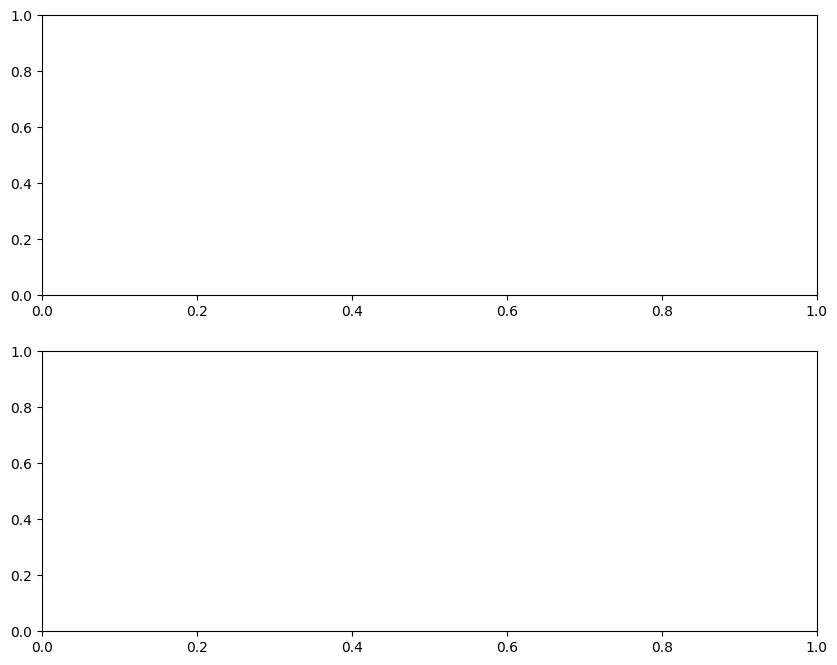

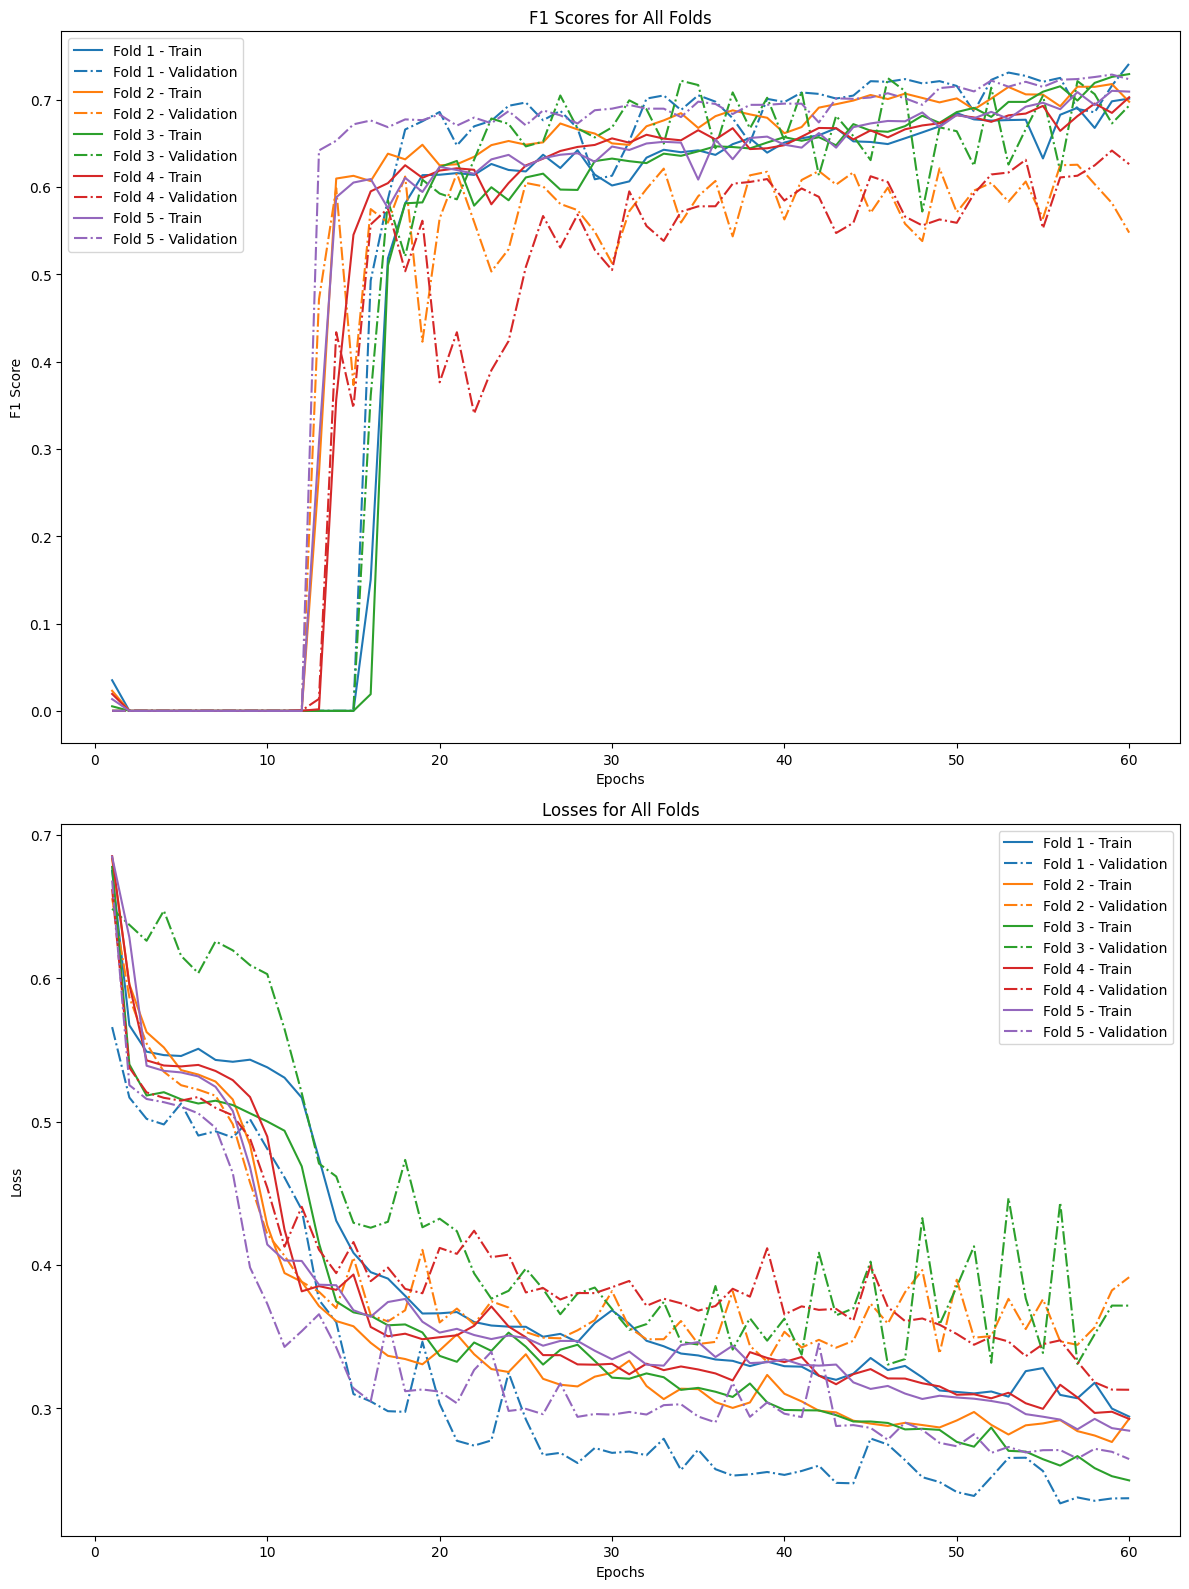

In [13]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.optimizers import AdamW

# Assume you have your data X and corresponding labels y
# Replace this with your actual data and labels

# Example data
X = train_images  # Assuming train_images is a list of images
y = train_masks   # Assuming train_masks is a list of masks

# Number of folds
k_fold = 5
epochs = 60
batch_size = 8

# Set seed for reproducibility
seed = 666

# Create KFold object with seed
kf = KFold(n_splits=k_fold, shuffle=True, random_state=seed)

# Store the results
result = []

# Store the results
f1_scores_train = []
f1_scores_val = []
losses_train = []
losses_val = []

# Create subplots for F1 scores and losses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# Create subplots for F1 scores and losses for all folds
fig_all_folds, axs_all_folds = plt.subplots(2, 1, figsize=(12, 16))

# Loop through the folds
for k, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    arr_X_train = []
    arr_X_val = []
    arr_y_train = []
    arr_y_val = []

    # Patching the train
    for img in range(X_train.shape[0]):
        image = X_train[img]
        new_mask = y_train[img]
        patches_img = patchify(image, (512, 512, 3), step=512)
        patches_mask = patchify(new_mask, (512, 512), step=512)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                arr_X_train.append(patches_img[i, j, :, :])
                arr_y_train.append(patches_mask[i, j, :, :])

    # Convert lists to NumPy arrays
    arr_X_train = np.array(arr_X_train)
    arr_y_train = np.array(arr_y_train)
    arr_X_train = arr_X_train.reshape((-1, 512, 512, 3))
    arr_y_train = arr_y_train.reshape((-1, 512, 512, 1)) # Reshape added

    # Print the shape of arrays
    print(f"Iteration {i} - arr_X_train shape: {arr_X_train.shape}, arr_y_train shape: {arr_y_train.shape}")
    # Print the shape of arrays
    print(f"Iteration {i} - arr_X_train shape: {arr_X_train.shape}, arr_y_train shape: {arr_y_train.shape}")

    # Patching the validation
    for img in range(X_val.shape[0]):
        image = X_val[img]
        new_mask = y_val[img]
        patches_img = patchify(image, (512, 512, 3), step=512)
        patches_mask = patchify(new_mask, (512, 512), step=512)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                arr_X_val.append(patches_img[i, j, :, :])
                arr_y_val.append(patches_mask[i, j, :, :])

    # Convert lists to NumPy arrays
    arr_X_val = np.array(arr_X_val)
    arr_y_val = np.array(arr_y_val)
    arr_X_val = arr_X_val.reshape((-1, 512, 512, 3))
    arr_y_val = arr_y_val.reshape((-1, 512, 512, 1))
    # Print the shape of arrays
    print(f"Iteration {i} - arr_X_val shape: {arr_X_val.shape}, arr_y_val shape: {arr_y_val.shape}")

    # Choose a unique color for each fold using the 'tab10' colormap
    color = plt.cm.tab10(k % 10)

    # Build the UNet model
    model = build_unet(input_shape, n_classes=1)

    optimizer = AdamW()

    # Build the UNet model
    model = build_unet(input_shape, n_classes=1)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1_m])

    # Model checkpoint
    output_directory = '/content/drive/MyDrive/TA Final/mc/'
    os.makedirs(output_directory, exist_ok=True)
    model_checkpoint_path = os.path.join(output_directory, f'fas_mnist_{k + 1}.keras')

    model_checkpoint = ModelCheckpoint(model_checkpoint_path,
                                       monitor='val_f1_m',
                                       mode='min',
                                       verbose=1,
                                       save_best_only=True)

    es = EarlyStopping(monitor='val_f1_m', mode='max', verbose=1, patience=30)
    # Train the model and collect metrics
    history = model.fit(arr_X_train,
                        arr_y_train,
                        validation_data=(arr_X_val, arr_y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[model_checkpoint,es],
                        shuffle=True)

    # Plot F1 scores and losses for training and validation for each fold
    color = plt.cm.tab10(k % 10)  # Adjust color based on the number of folds

    # Plot the F1 scores for training and validation for each fold on the same subplot
    axs_all_folds[0].plot(range(1, len(history.history['f1_m']) + 1), history.history['f1_m'],
                          label=f'Fold {k + 1} - Train', linestyle='solid', color=color)
    axs_all_folds[0].plot(range(1, len(history.history['val_f1_m']) + 1), history.history['val_f1_m'],
                          label=f'Fold {k + 1} - Validation', linestyle='dashdot', color=color)

    # Plot the losses for training and validation with the same color on the same subplot
    axs_all_folds[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'],
                          label=f'Fold {k + 1} - Train', linestyle='solid', color=color)
    axs_all_folds[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],
                          label=f'Fold {k + 1} - Validation', linestyle='dashdot', color=color)

# Set labels and title for F1 scores subplot
axs_all_folds[0].set_xlabel('Epochs')
axs_all_folds[0].set_ylabel('F1 Score')
axs_all_folds[0].legend()
axs_all_folds[0].set_title('F1 Scores for All Folds')

# Set labels and title for losses subplot
axs_all_folds[1].set_xlabel('Epochs')
axs_all_folds[1].set_ylabel('Loss')
axs_all_folds[1].legend()
axs_all_folds[1].set_title('Losses for All Folds')

# Save the plots for all folds in a single image
output_directory_all_folds = '/content/drive/MyDrive/TA Final/plot/all_folds/'
os.makedirs(output_directory_all_folds, exist_ok=True)
all_folds_plot_filename = 'All_Folds_Plot.jpg'
all_folds_plot_path = os.path.join(output_directory_all_folds, all_folds_plot_filename)
plt.tight_layout()
plt.savefig(all_folds_plot_path)
plt.show()
plt.close()  # Close the plot to release resources

In [14]:
image_names = glob.glob("/content/drive/MyDrive/TA Final/Dataset/Test/CLAHE/*.tif")
image_names.sort()
num_images = len(image_names)
image_names_subset = image_names[0:num_images]
image_name = np.array(image_names)
images = [cv2.imread(img, 1) for img in image_names_subset]
image_dataset = np.array(images)
mask_names = glob.glob("/content/drive/MyDrive/TA Final/Test/Masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
test_images = image_dataset
test_masks = mask_dataset

In [15]:
print("Image data shape is: ", test_images.shape)
print("Mask data shape is: ", test_masks.shape)
print("Labels in the mask are : ", np.unique(test_masks))

Image data shape is:  (14, 1024, 1024, 3)
Mask data shape is:  (14, 1024, 1024)
Labels in the mask are :  [  0 255]


In [16]:
#Normalize images
image_dataset = test_images/255.  #Can also normalize or scale using MinMax scaler

In [17]:
pip install patchify

In [18]:
#Load the model that was saved by ModelCheckpoint
from keras.models import load_model

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from patchify import patchify, unpatchify
from sklearn.preprocessing import LabelEncoder

# Specify the list of model file names with the new directory
model_directory = '/content/drive/MyDrive/TA Final/mc/'

model_files = [
    os.path.join(model_directory, 'fas_mnist_1.keras'),
    os.path.join(model_directory, 'fas_mnist_2.keras'),
    os.path.join(model_directory, 'fas_mnist_3.keras'),
    os.path.join(model_directory, 'fas_mnist_4.keras'),
    os.path.join(model_directory, 'fas_mnist_5.keras')
]

# Specify the output directory where you want to save the images and confusion matrices for each model
output_base_directory = "/content/drive/MyDrive/TA Final/"

# Create a common folder for confusion matrices
cm_output_directory = os.path.join(output_base_directory, 'ConfusionMatrices')
os.makedirs(cm_output_directory, exist_ok=True)

for model_file in model_files:
    # Load the model
    model = load_model(model_file, compile=False)
    model_file_name, _ = os.path.splitext(os.path.basename(model_file))

    # Create an empty list to store the reconstructed images
    reconstructed_images_list = []

    for msk in range(test_masks.shape[0]):
        test_img = image_dataset[msk]
        test_img = cv2.resize(test_img, (1024, 1024))
        patches_img = patchify(test_img, (512, 512, 3), step=512)
        predicted_patches = []

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch = patches_img[i, j, :, :, :]
                single_patch_prediction = model.predict(single_patch)

                # Apply threshold (adjust as needed)
                threshold = 0.5
                single_patch_prediction_binary = (single_patch_prediction >= threshold).astype(np.uint8)

                predicted_patches.append(single_patch_prediction_binary)

        predicted_patches = np.array(predicted_patches)
        predicted_patches_reshaped = np.reshape(predicted_patches, (patches_img.shape[0], patches_img.shape[1], 512, 512))
        reconstructed_image = unpatchify(predicted_patches_reshaped, [1024, 1024])

        reconstructed_images_list.append(reconstructed_image)

    reconstructed_images_list = np.array(reconstructed_images_list)
    print("Image data shape is: ", reconstructed_images_list.shape)

    labelencoder = LabelEncoder()
    n, h, w = test_masks.shape
    test_masks_reshaped = test_masks.reshape(-1, 1)
    test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
    test_masks_encoded = test_masks_reshaped_encoded.reshape(n, h, w)
    test_masks = keras.utils.to_categorical(test_masks_encoded, 2)
    test_masks = np.argmax(test_masks, axis=3)
    y_pred = reconstructed_images_list
    y_true = test_masks

    # Compute the confusion matrix
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())

    # Create a heatmap of the non-normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    print(model_file_name)

    # Save the non-normalized confusion matrix plot
    cm_output_path = os.path.join(cm_output_directory, f'{model_file_name}_confusion_matrix_non_normalized.png')
    plt.savefig(cm_output_path)
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap of the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    print(model_file_name)
    # Save the confusion matrix plot
    cm_output_path = os.path.join(cm_output_directory, f'{model_file_name}_confusion_matrix.png')
    plt.savefig(cm_output_path)
    plt.show()

    # Save the reconstructed images
    pred_output_directory = os.path.join(output_base_directory, 'Preds/')
    output_directory = os.path.join(pred_output_directory, model_file_name)
    os.makedirs(output_directory, exist_ok=True)
    y_pred = y_pred * 255  # Assuming y_pred is correctly scaled to 0-255
    for pred_image, name in zip(y_pred, image_names):
        name = os.path.basename(name)
        output_path = os.path.join(output_directory, f"{name}.tif")
        cv2.imwrite(output_path, pred_image)

        print(f"Saved {name} to {output_path}")

ValueError: File not found: filepath=/content/drive/MyDrive/TA Final/mc/fas_mnist_1.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/TA Final/Dataset/CLAHE/*.tif")
image_names.sort()
num_images = len(image_names)
image_names_subset = image_names[0:num_images]
image_name = np.array(image_names)
images = [cv2.imread(img, 1) for img in image_names_subset]
image_dataset = np.array(images)
mask_names = glob.glob("/content/drive/MyDrive/TA Final/Dataset/Normalized/Mask/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
test_images = image_dataset
test_masks = mask_dataset

In [ ]:
#Normalize images
image_dataset = test_images/255.  #Can also normalize or scale using MinMax scaler

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from patchify import patchify, unpatchify
from sklearn.preprocessing import LabelEncoder

# Specify the list of model file names with the new directory
model_directory = '/content/drive/MyDrive/TA Final/mc/'

model_files = [
    os.path.join(model_directory, 'fas_mnist_1.h5'),
    os.path.join(model_directory, 'fas_mnist_2.h5'),
    os.path.join(model_directory, 'fas_mnist_3.h5'),
    os.path.join(model_directory, 'fas_mnist_4.h5'),
    os.path.join(model_directory, 'fas_mnist_5.h5')
]

# Specify the output directory where you want to save the images and confusion matrices for each model
output_base_directory = "/content/drive/MyDrive/TA Final/Train/"

# Create a common folder for confusion matrices
cm_output_directory = os.path.join(output_base_directory, 'ConfusionMatrices')
os.makedirs(cm_output_directory, exist_ok=True)

for model_file in model_files:
    # Load the model
    model = load_model(model_file, compile=False)
    model_file_name, _ = os.path.splitext(os.path.basename(model_file))

    # Create an empty list to store the reconstructed images
    reconstructed_images_list = []

    for msk in range(test_masks.shape[0]):
        test_img = image_dataset[msk]
        test_img = cv2.resize(test_img, (1024, 1024))
        patches_img = patchify(test_img, (512, 512, 3), step=512)
        predicted_patches = []

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch = patches_img[i, j, :, :, :]
                single_patch_prediction = model.predict(single_patch)

                # Apply threshold (adjust as needed)
                threshold = 0.5
                single_patch_prediction_binary = (single_patch_prediction >= threshold).astype(np.uint8)

                predicted_patches.append(single_patch_prediction_binary)

        predicted_patches = np.array(predicted_patches)
        predicted_patches_reshaped = np.reshape(predicted_patches, (patches_img.shape[0], patches_img.shape[1], 512, 512))
        reconstructed_image = unpatchify(predicted_patches_reshaped, [1024, 1024])

        reconstructed_images_list.append(reconstructed_image)

    reconstructed_images_list = np.array(reconstructed_images_list)
    print("Image data shape is: ", reconstructed_images_list.shape)

    labelencoder = LabelEncoder()
    n, h, w = test_masks.shape
    test_masks_reshaped = test_masks.reshape(-1, 1)
    test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
    test_masks_encoded = test_masks_reshaped_encoded.reshape(n, h, w)
    test_masks = keras.utils.to_categorical(test_masks_encoded, 2)
    test_masks = np.argmax(test_masks, axis=3)
    y_pred = reconstructed_images_list
    y_true = test_masks

    # Compute the confusion matrix
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())

    # Create a heatmap of the non-normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    print(model_file_name)

    # Save the non-normalized confusion matrix plot
    cm_output_path = os.path.join(cm_output_directory, f'{model_file_name}_confusion_matrix_non_normalized.png')
    plt.savefig(cm_output_path)
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap of the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    print(model_file_name)
    # Save the confusion matrix plot
    cm_output_path = os.path.join(cm_output_directory, f'{model_file_name}_confusion_matrix.png')
    plt.savefig(cm_output_path)
    plt.show()

    # Save the reconstructed images
    pred_output_directory = os.path.join(output_base_directory, 'Preds/')
    output_directory = os.path.join(pred_output_directory, model_file_name)
    os.makedirs(output_directory, exist_ok=True)
    y_pred = y_pred * 255  # Assuming y_pred is correctly scaled to 0-255
    for pred_image, name in zip(y_pred, image_names):
        name = os.path.basename(name)
        output_path = os.path.join(output_directory, f"{name}.jpg")
        cv2.imwrite(output_path, pred_image)

        print(f"Saved {name} to {output_path}")